<a href="https://colab.research.google.com/github/Yanina-Kutovaya/projects/blob/main/Sales_forecast_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales forecast model for 20 stores 31 days in advance. 

Evaluation Metric - Scaled Mean Absolute Error (sMAE).

Files:
* Training sample file: train.csv (attached)
* File with test sample (without target variables): test.csv (attached)
* Example file format with the result of the prediction: predict_example.csv (attached)

Decision evaluation
Assessment of the decision will be made according to the following criteria:
* Achieved metric value: sMAE < 0.12 is desirable.
* Exploratory data analysis: what characteristics of the source data were analyzed, what conclusions and/or
hypotheses were put forward, what types of analysis were performed.
* Code quality: structured, understandable (clean), documented, computational optimality.
* The choice of machine learning method, its validity.
* The choice of a validation strategy, its validity.
* Selection of hyperparameters for the selected machine learning method (if any): what values, by which
strategy were selected.
* Conclusions from the results of the study.

In [ ]:
!pip install tensorflow_addons

In [ ]:
import numpy as np
import pandas as pd
import math

import missingno as msno
import scipy.stats as st
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow import keras 
from keras import layers
from keras.losses import Loss
from keras.models import Model
from keras import backend as K

from tensorflow_addons.layers import MultiHeadAttention

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = '/content/drive/My Drive/app/ML_in_business/9_sales_forecast/'

## 1. Data download

In [ ]:
train = pd.read_csv(PATH + 'train.csv')
print(f'train.shape = {train.shape}')
train.head(2)

train.shape = (8230, 3)


,id,dt,target
0,0,2016-01-02,747.8
1,0,2016-01-03,681.2


In [ ]:
test = pd.read_csv(PATH + 'test.csv')
print(f'test.shape = {test.shape}')
test.tail(2)

test.shape = (540, 2)


,id,dt
538,19,2017-07-30
539,19,2017-07-31


In [ ]:
predict_example = pd.read_csv(PATH + 'predict_example.csv')
print(f'test.shape = {predict_example.shape}')
predict_example.head(2)

test.shape = (540, 3)


,id,dt,target
0,0,2017-07-01,500
1,0,2017-07-02,500


## 2. Data preprocessing

In [ ]:
df = pd.concat([train, test], axis=0)
df.dtypes

id          int64
dt         object
target    float64
dtype: object

In [ ]:
df['id'] = df['id'].astype('int8')
df['dt'] = pd.to_datetime(df['dt'])
df.dtypes

id                  int8
dt        datetime64[ns]
target           float64
dtype: object

## 3. EDA

In [ ]:
n_shops = df['id'].nunique()
n_shops

20

### 3.1 Omissions

#### Test data

In [ ]:
df_test = df[df['target'].isnull()]
test_days = pd.pivot_table(
    df_test, values='target', index=['dt'], columns=['id'], aggfunc=np.sum
    ).reset_index(level=-1)['dt'].tolist()

print(f'test period from {test_days[0].date()} till {test_days[-1].date()}')
print(f'output length = {len(test_days)}')

d0 = test_days[0].weekday()
d1 = test_days[-1].weekday()
print(f'prediction start and end weekdays: {d0, d1}')

test period from 2017-07-01 till 2017-07-31
output length = 27
prediction start and end weekdays: (5, 0)


In [ ]:
def get_missing_days_weekdays(missing_days):
  n_missing_days = 0
  for weekday in range(7):
    n_days_off = len([i for i in missing_days if i.weekday() == weekday])
    if n_days_off:
      n_missing_days += n_days_off
      print(weekday, n_days_off)

In [ ]:
test_calendar_days = pd.date_range(start=test_days[0], end=test_days[-1])
missing_test_days = [i for i in test_calendar_days if i not in test_days]

get_missing_days_weekdays(missing_test_days)

2 4


__Conclusions:__
* Prediction period from 2017-07-01 till 2017-07-31
* Prediction should be made for 27 consequent days starting on Friday and ending on Sunday
* Tuesdays are days-off


#### Train data


##### Full data omissions

In [ ]:
df_train = df[~df['target'].isnull()]
data = pd.pivot_table(
    df_train, values='target', index=['dt'], columns=['id'], aggfunc=np.sum
    ).reset_index(level=-1)
data.columns = ['dt'] + list(range(n_shops))
data.set_index('dt', inplace=True)

print(f'train data available from {data.index[0].date()} till {data.index[-1].date()}')

calendar_days = pd.date_range(start=data.index[0], end=data.index[-1])
print(f'number of calendar days in observed period = {len(calendar_days)}')
print(f'number of available days of observation = {data.shape[0]}')

data.tail(2)

train data available from 2016-01-02 till 2017-06-30
number of calendar days in observed period = 546
number of available days of observation = 453


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
dt,,,,,,,,,,,,,,,,,,,,
2017-06-29,1039.9,717.1,820.9,721.0,453.5,630.8,944.2,847.9,1875.8,1169.7,840.1,786.9,1472.9,977.7,951.0,1204.2,829.0,915.1,1029.9,739.1
2017-06-30,1152.9,717.1,823.5,606.6,405.8,581.9,871.9,961.1,1798.1,935.4,860.9,742.2,1648.4,983.2,846.5,1128.9,783.5,859.9,961.5,629.7


In [ ]:
missing_days = [i for i in calendar_days if not i in data.index]
get_missing_days_weekdays(missing_days)

0 6
1 8
2 70
3 4
6 5


In [ ]:
len([i for i in calendar_days if i.weekday()==2])

78

As Tuesdays are the days-off, they are missing from the dataset. However, there are 78 Tuesdays in the training period.  

Among the missing data we have 70 Tuesdays and 8 Mondays. 
It looks that days-off were switched from Mondays to Tuesdays.

In [ ]:
for month in range(1, 13):
  month_days_off = [i for i in missing_days if (i.month == month) & (i.weekday() != 2) ]
  n_days_off = len(month_days_off)
  if n_days_off:
    print(f'month {month}, n_days_off apart from Tuesday = {n_days_off}:')
    for year in [2016, 2017]:
      days_off_list = [i.day for i in month_days_off if i.year == year]    
      if days_off_list:
        print(f'{year}:', *days_off_list)
    for weekday in range(7):
      n = len([i for i in month_days_off if i.weekday() == weekday])
      if n: print(weekday, n)

month 1, n_days_off apart from Tuesday = 5:
2016: 5 12 19 26
2017: 1
1 4
6 1
month 2, n_days_off apart from Tuesday = 5:
2016: 2 9 16 23 29
0 1
1 4
month 4, n_days_off apart from Tuesday = 4:
2016: 18 21
2017: 3 6
0 2
3 2
month 5, n_days_off apart from Tuesday = 5:
2016: 1 29
2017: 1 14 25
0 1
3 1
6 3
month 6, n_days_off apart from Tuesday = 1:
2016: 9
3 1
month 10, n_days_off apart from Tuesday = 1:
2016: 3
0 1
month 12, n_days_off apart from Tuesday = 2:
2016: 25 26
0 1
6 1


__Fill full omissions:__

medians

In [ ]:
col_name = 'ind'
data[col_name] = [str(i.month) + '_' + str(i.weekday()) for i in data.index]

items = data[col_name].unique()
medians = pd.DataFrame(index=range(n_shops), columns=items)
for item in items: 
  medians.loc[:, item] = data[data[col_name] == item].median(axis=0)

data.drop([col_name], axis=1, inplace=True)
medians.head(2)

,1_5,1_6,1_0,1_2,1_3,1_4,2_0,2_2,2_3,2_4,...,11_6,11_0,12_3,12_4,12_5,12_6,12_0,12_1,1_1,2_1
0,769.9,793.4,624.2,771.95,893.75,770.10,630.65,841.75,813.1,755.25,...,916.10,890.25,1138.8,1065.5,677.0,1166.5,1088.5,834.15,532.8,546.6
1,467.1,485.1,418.6,500.10,491.60,471.95,402.85,505.15,455.2,449.15,...,520.65,592.50,860.3,780.2,452.7,741.3,784.0,466.10,326.9,366.0


In [ ]:
full_omission_dates = ['2016-02-29',                       
                       '2016-04-18',
                       '2016-04-21',
                       '2016-05-01',
                       '2016-05-29',
                       '2016-06-09',
                       '2016-10-03',
                       '2016-12-25',
                       '2016-12-26',
                       '2017-01-01',
                       '2017-04-03',
                       '2017-04-06',
                       '2017-05-01',
                       '2017-05-14',
                       '2017-05-25']

full_omission_dates = pd.to_datetime(full_omission_dates)
full_omissions = pd.DataFrame(index=full_omission_dates, columns=[col_name])
full_omissions[col_name] = [
  str(i.month) + '_' + str(i.weekday()) for i in full_omission_dates]
                           
full_omissions.head(2)

,ind
2016-02-29,2_0
2016-04-18,4_0


In [ ]:
items = full_omissions[col_name].unique()
df1 = pd.DataFrame(index=full_omission_dates, columns=data.columns)
for item in items:  
  ind = full_omissions[full_omissions[col_name] == item].index  
  df1.loc[ind, :] = medians.loc[:, item].tolist()

shops = [4, 8, 10, 13, 17]
ind = ind = pd.to_datetime(['2016-10-03', '2016-12-25','2016-12-26'])
df1.loc[ind, shops] = np.nan

data = pd.concat([data, df1], axis=0).sort_index() 

Consistency check:

In [ ]:
calendar_days = pd.date_range(start=data.index[0], end=data.index[-1])
date_omissions = [i.date() for i in calendar_days if (
    # the date is not accounted for in data
    (not (i in data.index)) &\
    # excluding days-of on Tuesdays starting Mar 2016
    ~((i.weekday() == 2) & (i >= pd.to_datetime('2016-03-01'))) &\
    # excluding days-off on Mondays in Jan and Feb 2016
    ~((i.year == 2016) & (i < pd.to_datetime('2016-03-01')))
    )]
    
if date_omissions:
  print('Date omissions:', *date_omissions)

__Conclusions:__
* Train data is available from 2016-01-02 till 2017-06-30.
* In January and February 2016 days-off were on Mondays and starting from March 2016 days-off were switched to Tuesdays. 
* February missing data: 
  * 2016 - 29 Feb
* April missing data: 
  * 2016 - 18, 21, 
  * 2017 - 3, 6
* May missing data: 
  * 2016 - 29, 
  * 2017 - 14, 25
* June missing data: 
  * 2016 - 9
* October missing data: 2016 - 3 Oct
* Holydays: 1 Jan, 1 May, 25-26 Dec

Missing data was filled by the medians for particular days of the week of corresponding shops.

##### Partial data omission

__matrix__

Nullity matrix lets us quickly visually pick out patterns in data completion.

From the diagram below we can see the time periods when the data for each of the 20 shops were missing

The sparkline at right summarizes the general shape of the data completeness and points out the rows with the maximum and minimum nullity in the dataset.

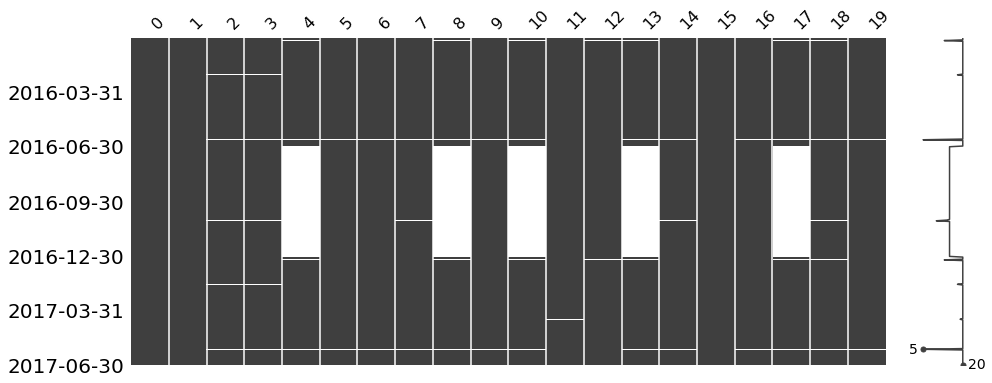

In [ ]:
msno.matrix(data.set_index(data.index), freq='BQ', figsize=(15, 6));

__bar__

The bar diagram shows the data available for each shop in both absolte and relative terms.

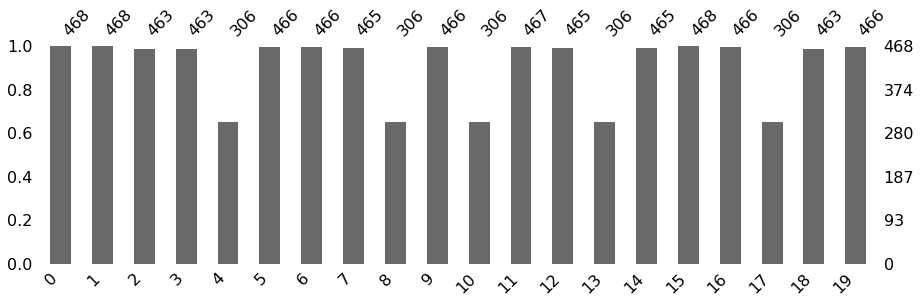

In [ ]:
msno.bar(data, figsize=(15, 4));

__heatmap__

Correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another.

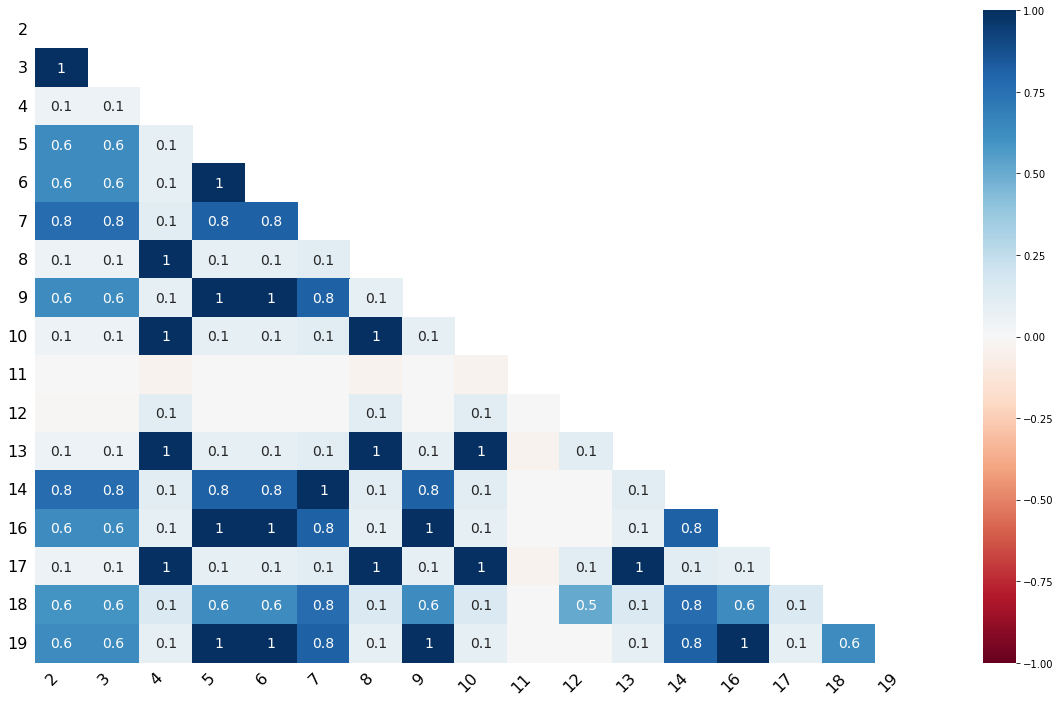

In [ ]:
msno.heatmap(data);

__dendrogram__

The dendrogram reveals trends deeper than the pairwise ones visible in the correlation heatmap above.

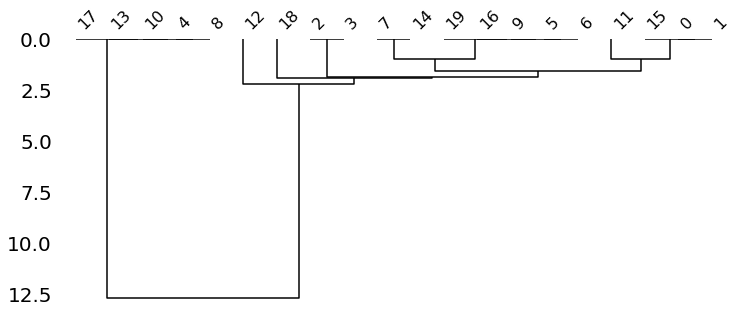

In [ ]:
msno.dendrogram(data, figsize=(12, 5));

__Shops 4, 8, 10, 13, 17:__ 

In [ ]:
list_1 = [4, 8, 10, 13, 17]
ind_1 = data.index[data[list_1[0]].isnull().values]
print(*[ind_1[i].date() for i in [0, 1, 2, -3, -2, -1]])

2016-01-06 2016-06-19 2016-07-01 2016-12-31 2017-01-06 2017-06-04



* data for 2 quaters from 2016-07-01 till 2016-12-31 is missing
* the other dates with missing data: 
  * 2016: Jan 6, Jun 19
  * 2017: Jan 6, Jun 4

__Shops 2, 3:__

In [ ]:
shop = 2
data.index[data[shop].isnull().values]

DatetimeIndex(['2016-03-03', '2016-06-19', '2016-11-01', '2017-02-16',
               '2017-06-04'],
              dtype='datetime64[ns]', freq=None)


* the dates with missing data: 
  * 2016: Mar 3, Jun 19, Nov 1
  * 2017: Feb 16, Jun 4


__Shop 18:__

In [ ]:
shop = 18
data.index[data[shop].isnull().values]

DatetimeIndex(['2016-01-06', '2016-06-19', '2016-11-01', '2017-01-06',
               '2017-06-04'],
              dtype='datetime64[ns]', freq=None)


* the dates with missing data: 
  * 2016: Jan 6, Jun 19, Nov 1
  * 2017: Jan 6, Jun 4

In [ ]:
shop = 7
data.index[data[shop].isnull().values]

DatetimeIndex(['2016-06-19', '2016-11-01', '2017-06-04'], dtype='datetime64[ns]', freq=None)

__Shops 7, 14:__
* the dates with missing data: 
  * 2016: Jun 19, Nov 1
  * 2017: Jun 4

In [ ]:
shop = 12
data.index[data[shop].isnull().values]

DatetimeIndex(['2016-01-06', '2016-10-31', '2017-01-06'], dtype='datetime64[ns]', freq=None)

__Shop 12:__
* the dates with missing data: 
  * 2016: Jan 6, Oct 31
  * 2017: Jan 6

In [ ]:
shop = 5
data.index[data[shop].isnull().values]

DatetimeIndex(['2016-06-19', '2017-06-04'], dtype='datetime64[ns]', freq=None)

__Shops 5, 6, 9, 16, 19:__
* the dates with missing data: 
  * 2016: Jun 19
  * 2017: Jun 4

In [ ]:
shop = 11
data.index[data[shop].isnull().values]

DatetimeIndex(['2017-04-15'], dtype='datetime64[ns]', freq=None)

__Shops 11:__
* the dates with missing data:  
  * 2017: Apr 15

__Fill partial omissions:__

In [ ]:
partial_omission_dates = {'2016-01-06': [4, 8, 10, 12, 13, 17, 18],                          
                          '2016-03-03': [2, 3],
                          '2016-06-19': [i for i in np.arange(n_shops) if not i in [0, 1, 11, 12, 15]],
                          '2016-10-31': [12],
                          '2016-11-01': [2, 3, 7, 14, 18],
                          '2017-01-06': [4, 8, 10, 12, 13, 17, 18],
                          '2017-02-16': [2, 3],
                          '2017-04-15': [11],
                          '2017-06-04': [i for i in np.arange(n_shops) if not i in [0, 1, 11, 12, 15]]
                          }

ind = pd.to_datetime(list(partial_omission_dates.keys())) 
partial_omissions = pd.DataFrame(index=ind, columns=[col_name])
partial_omissions[col_name] = [str(i.month) + '_' + str(i.weekday()) for i in ind]
partial_omissions.head(2)

,ind
2016-01-06,1_2
2016-03-03,3_3


In [ ]:
for key in partial_omission_dates.keys():
  ind = pd.to_datetime(key)
  item = str(ind.month) + '_' + str(ind.weekday()) 
  shops = partial_omission_dates[key]
  data.loc[ind, shops] = medians.loc[shops, item].tolist()

__Adjust data for the change of days-off__

For January and Febuary 2016 shift days-off from Mondays to Tuesdays.
* Wednesdays will represent Mondays which were days-off before
* Tuesdays data will shift to Wednestdays as the days that followed the days-off.
* Finally, Tuesdays data will be deleted as Tuesdays become the days-off.

In [ ]:
print(pd.to_datetime('2016-01-05').weekday())
mondays = np.arange(np.datetime64('2016-01-05'), np.datetime64('2016-03-01'), 7)
tuesdays = np.arange(np.datetime64('2016-01-06'), np.datetime64('2016-03-01'), 7)
wednesdays = np.arange(np.datetime64('2016-01-07'), np.datetime64('2016-03-01'), 7)

# Add Wednesdays as Mondays
a = pd.DataFrame(data=data.loc[wednesdays, :].values,
                 index=mondays, columns=range(n_shops))
data = pd.concat([a, data], axis=0).sort_index()

# Overwrite Wednesday by Tuesday
data.loc[wednesdays, :] = data.loc[tuesdays, :].values

# Drop tuesdays as days-off
data = data.drop(index=tuesdays)

1


#### Conclusions
* Distribution of sales in Jan and Feb 2016 when days-off were on Mondays differs from the distribution afterwards, when days-off switched to Tuesdays. So data for Jan and Feb 2016 were adjusted for the change of days-off be used in training of the model.

* Missing data is filled by the medians of particular day of the week for each respective shop.

### 3.2 Descriptive statistics

In [ ]:
data = data.astype('float32')
stats = data.describe()
round(stats, 1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,468.0,468.0,468.0,468.0,310.0,468.0,468.0,468.0,310.0,468.0,310.0,468.0,468.0,310.0,468.0,468.0,468.0,310.0,468.0,468.0
mean,779.8,487.7,596.5,437.7,385.7,455.0,642.8,634.7,1547.8,781.6,675.3,516.5,780.6,689.1,609.0,811.0,447.8,485.4,648.7,455.6
std,191.9,123.1,107.1,148.1,53.8,108.5,166.3,114.1,292.0,183.7,102.7,135.8,282.6,126.8,177.7,181.7,96.0,147.0,177.0,135.3
min,370.2,263.3,306.6,174.3,250.8,223.5,350.7,324.6,985.5,393.4,449.3,289.0,285.5,401.9,261.2,497.6,221.5,276.5,338.7,193.8
25%,631.1,397.4,512.2,325.6,348.2,369.3,516.2,548.4,1334.7,640.2,594.3,406.2,613.0,587.8,486.4,672.5,378.3,367.4,505.7,355.0
50%,761.6,475.8,579.9,423.0,380.6,448.9,623.1,614.1,1532.9,748.6,669.2,488.6,739.8,669.7,586.9,770.1,432.7,459.7,609.6,435.5
75%,897.9,551.2,670.1,542.8,420.5,520.0,737.9,707.8,1725.1,884.5,752.9,591.8,952.3,781.8,719.7,895.0,491.3,556.0,764.1,541.3
max,1385.5,1021.9,909.4,870.5,545.2,920.4,1209.0,1007.5,2680.7,1568.6,1102.1,987.4,1766.1,1098.1,1210.7,1584.3,909.1,1191.7,1225.8,1028.2


__Box plot__

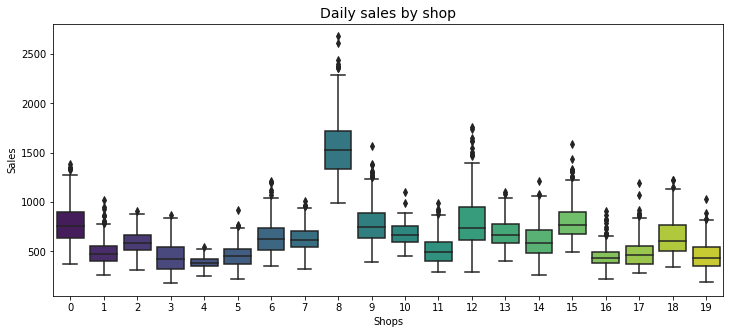

In [ ]:
plt.figure(figsize=(12, 5))
plt.title('Daily sales by shop', size=14)
plt.xlabel('Shops')
plt.ylabel('Sales')
sns.boxplot(data=data, palette="viridis");

__Conclusions:__
* Shop 8 has the highest sales and missing half a year of data. It will have high impact on forecast. 
* The impact of the other shops with missing data (4, 10, 13, 17) is relatively moderate.
* Nearly all of the shops has outliers on the upper bound.

__Correlation heat map__

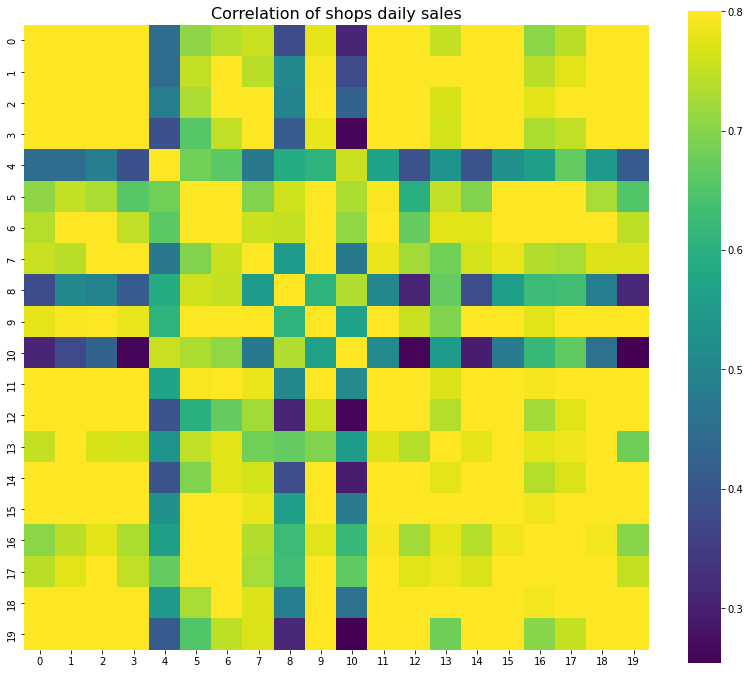

In [ ]:
correlation = data.corr()
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation of shops daily sales", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")
plt.show()

In [ ]:
correlated_shops = {4: [5,6],
                    8: [5, 6],
                    10: [5, 6],
                    13: [1, 6, 11, 14, 15, 18],
                    17: [2, 5, 6, 9, 11, 15, 16, 18]}


for i in correlated_shops.keys():
  cols = correlated_shops[i]
  model = LinearRegression() 
  model.fit(data.loc[~data[i].isnull(), cols], data.loc[~data[i].isnull(), i])
  predictions = model.predict(data.loc[data[i].isnull(), cols])
  data.loc[data[i].isnull(), i] = predictions                   

__Conclusions:__
* Sales of the shops with missing data 4, 8 and 10 have low correlation with the sales of the other shops. It is practical use only data from shops 5 and 6 to impute missing values for shops 4, 8 and 10.

* The better options for imputing missing data exist for the shops 13 and 17:
  * Sales of the shop 13 are highly correlated with the ons of shops 1, 6, 11, 14, 15, 18.
  * Sales of the shop 17 are highly correlated with the ons of shops 2, 5, 6, 9, 11, 15, 16, 18.


In [ ]:
def get_distribution(data, shop):
  target = data[shop]
  fig, axes = plt.subplots(1, 3, figsize=(12, 3))

  axes[0].set_title("Johnson SU", fontsize=14)
  sns.distplot(target, kde=False, color="blue", fit=st.johnsonsu, ax=axes[0])

  axes[1].set_title("Normal", fontsize=14)
  sns.distplot(target, kde=False, color="blue", fit=st.norm, ax=axes[1])

  axes[2].set_title("Log Normal", fontsize=14)
  sns.distplot(target, kde=False, color="blue", fit=st.lognorm, ax=axes[2])
  plt.show()

Shop 0


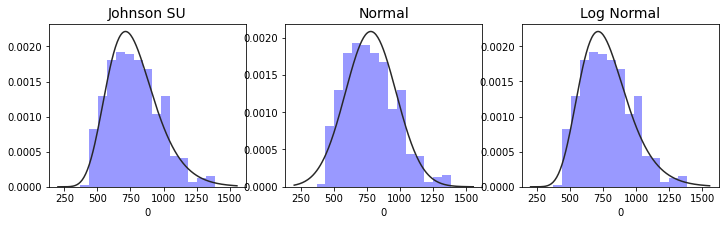

Shop 1


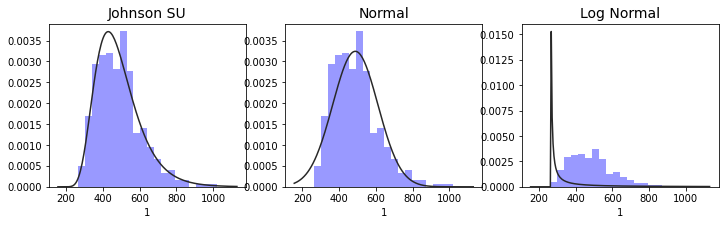

Shop 2


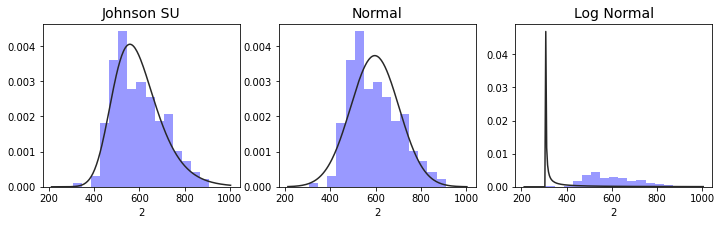

Shop 3


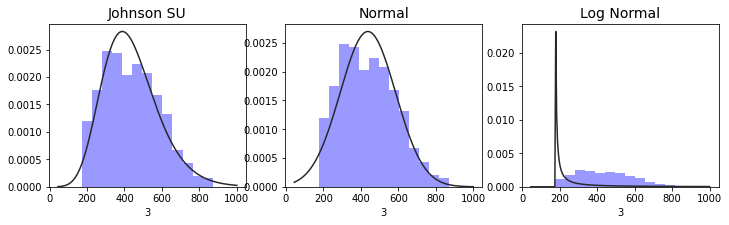

Shop 4


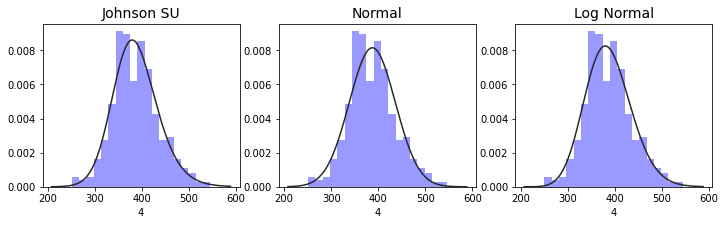

Shop 5


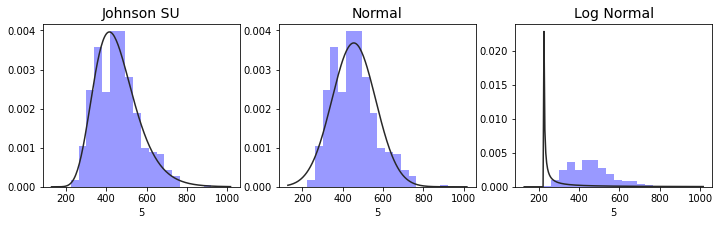

Shop 6


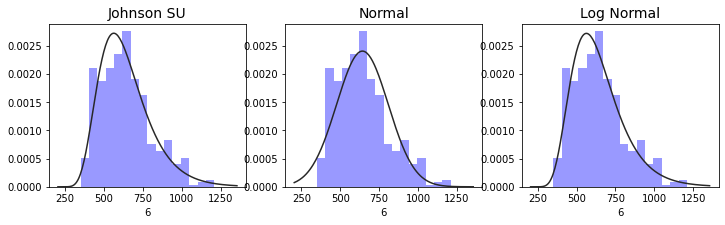

Shop 7


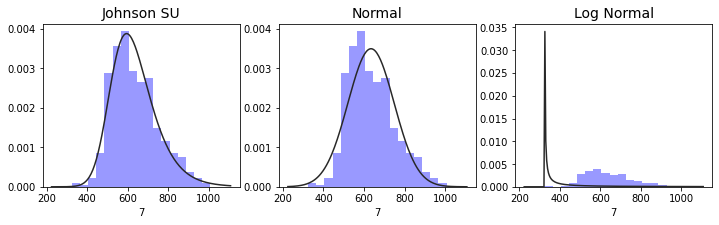

Shop 8


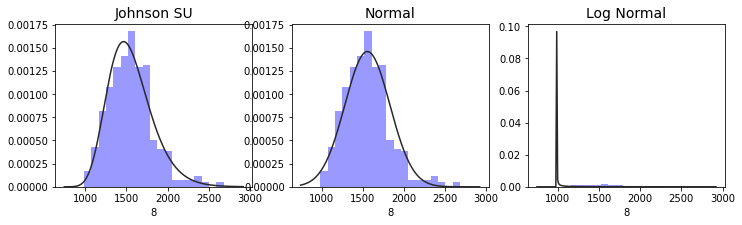

Shop 9


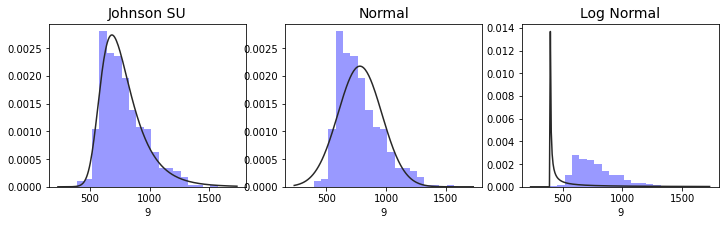

Shop 10


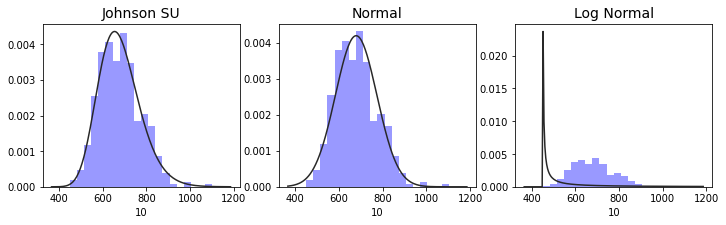

Shop 11


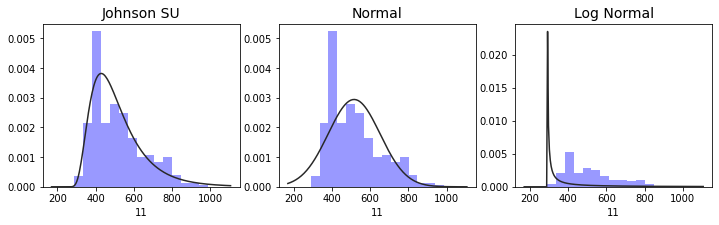

Shop 12


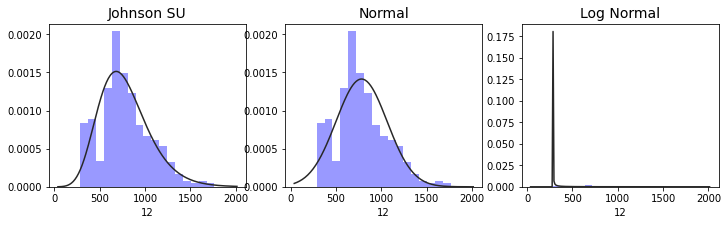

Shop 13


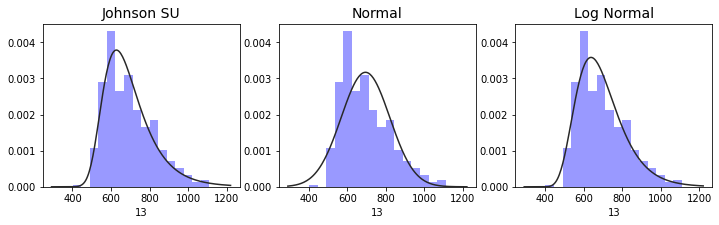

Shop 14


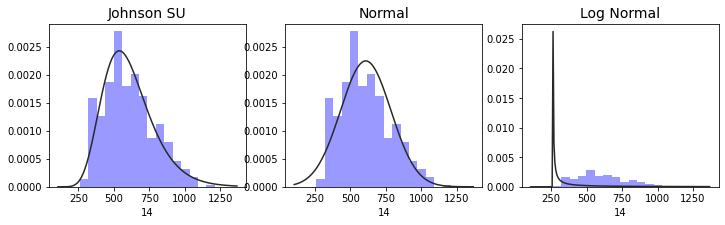

Shop 15


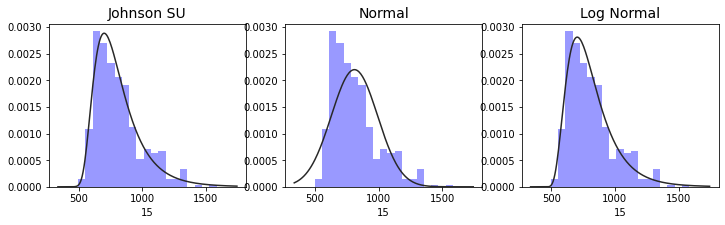

Shop 16


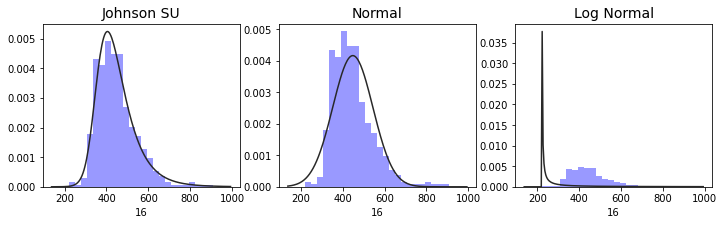

Shop 17


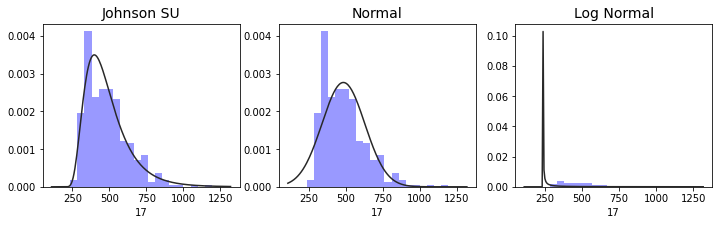

Shop 18


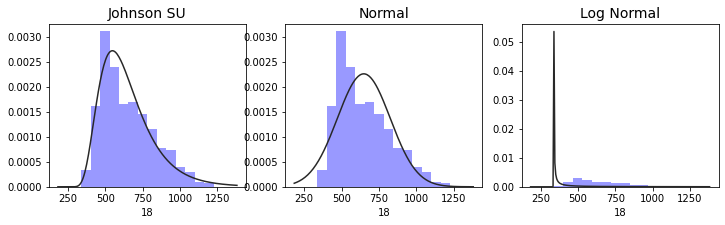

Shop 19


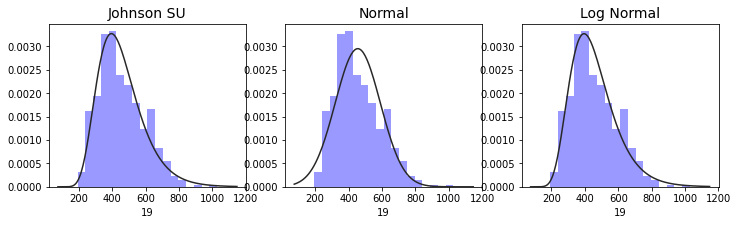

In [ ]:
for shop in range(n_shops):
  print(f'Shop {shop}')
  get_distribution(data, shop)

__Conclusion:__
It is obvious that target variable is not normally distributed. The closest approximation is Johnson SU distribution.

#### Median sales by month

In [ ]:
def plot_median_sales_by_month(shop):  
  plt.figure(figsize=(12, 3))
  plt.grid()  
  x = resampled_data.index - pd.to_timedelta(30, 'D')
  plt.scatter(x, resampled_data[shop])
  plt.title(f'Daily sales shop {shop}')
  plt.xlabel('time')
  plt.ylabel('sales')
  plt.show;

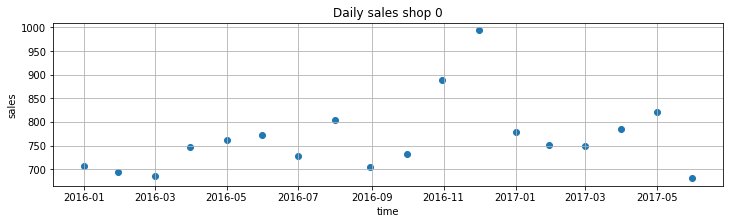

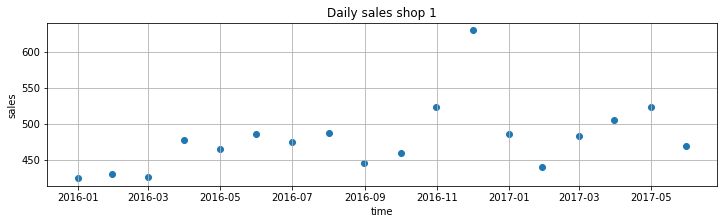

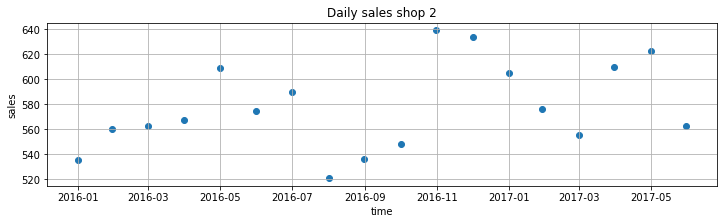

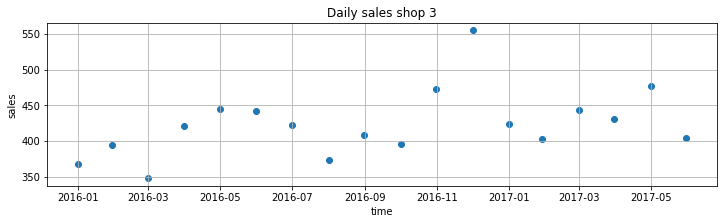

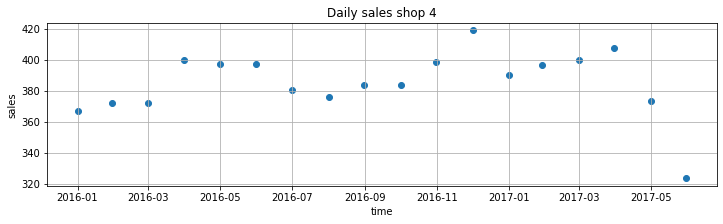

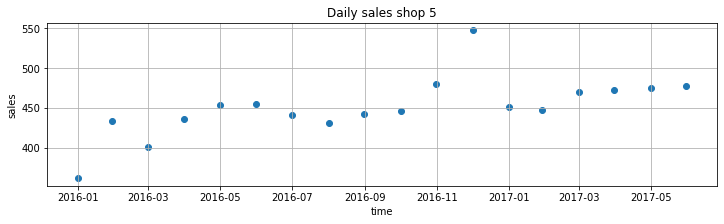

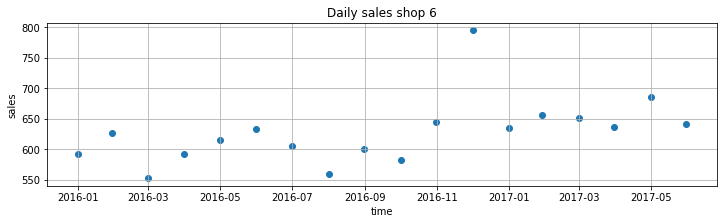

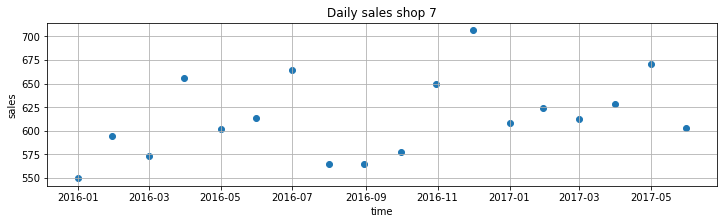

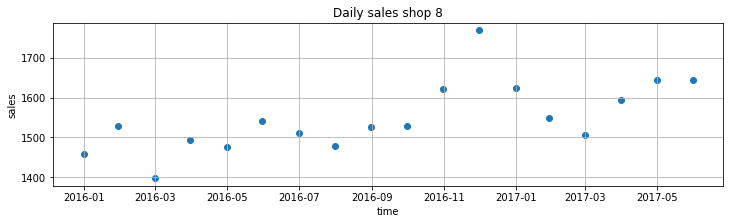

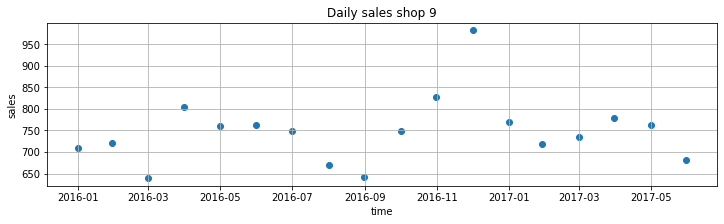

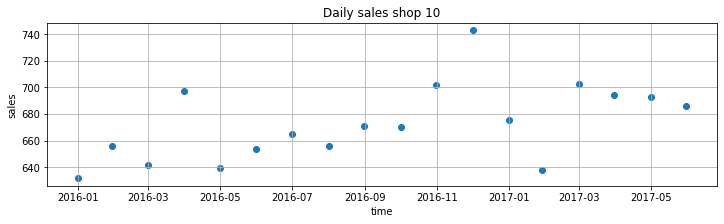

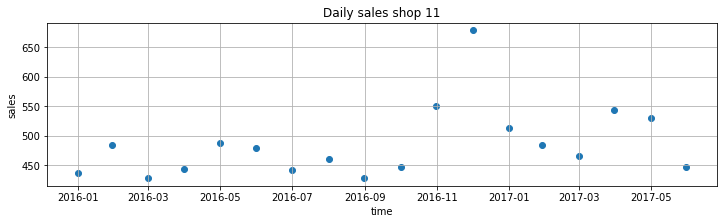

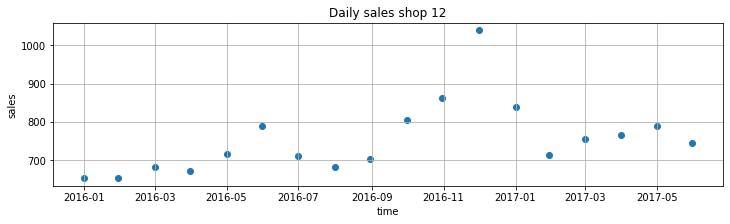

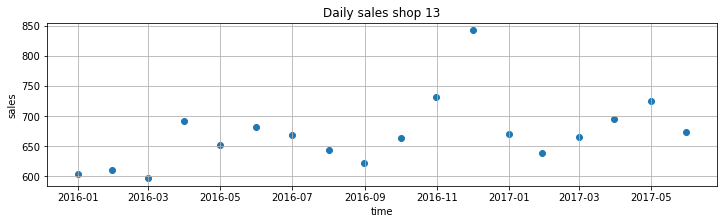

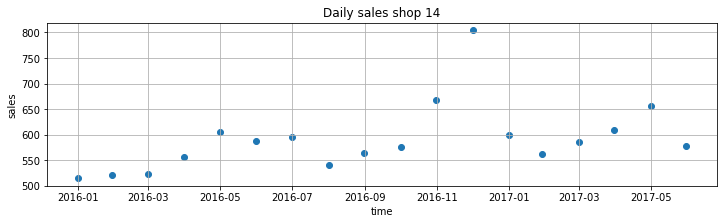

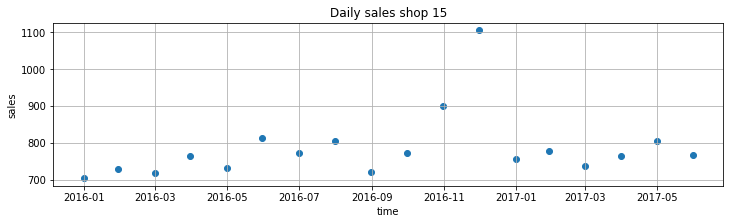

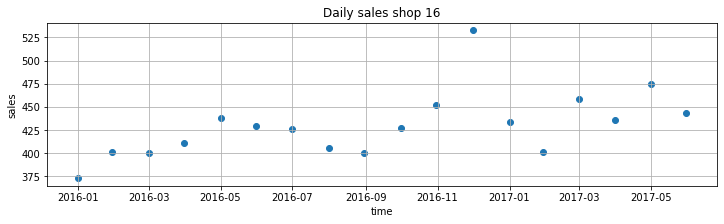

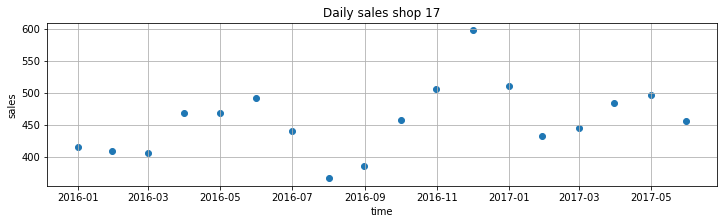

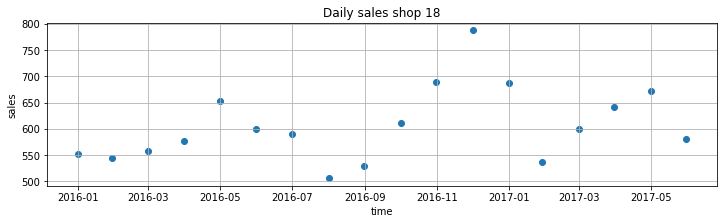

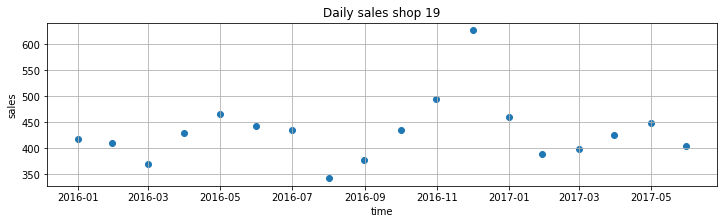

In [ ]:
resampled_data = data.resample('M').median()
for shop in range(n_shops):
  plot_median_sales_by_month(shop)

In [ ]:
data = data.astype('float32')
month_medians = pd.pivot_table(data, index=data.index.month, aggfunc=np.median)

month_medians

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1,755.799988,458.399994,573.799988,411.500000,381.000000,420.600006,613.400024,602.000000,1555.800049,726.900024,650.000000,486.700012,713.000000,659.400024,531.099976,757.500000,410.000000,461.100006,617.200012,430.100006
2,741.200012,430.799988,573.900024,394.149994,375.000000,440.399994,638.099976,609.099976,1528.500000,721.799988,651.099976,484.700012,677.500000,633.900024,523.900024,746.299988,401.700012,426.899994,537.599976,400.799988
3,720.950012,441.149994,559.049988,397.100006,382.450012,438.750000,602.549988,599.199951,1449.199951,683.199951,661.550049,443.549988,723.500000,632.599976,560.000000,732.750000,442.600006,427.850006,575.099976,378.649994
4,769.150024,493.450012,598.400024,421.649994,404.950012,451.100006,621.450012,646.849976,1518.250000,785.099976,697.000000,479.000000,711.849976,692.349976,583.250000,764.150024,423.700012,470.349976,610.300049,426.099976
5,797.900024,500.700012,620.700012,449.700012,393.399994,470.899994,645.000000,642.700012,1603.500000,760.599976,688.500000,508.299988,775.900024,686.650024,645.400024,775.900024,464.899994,477.299988,658.299988,450.799988
6,741.400024,481.799988,574.599976,422.799988,363.500000,461.000000,632.500000,612.799988,1607.300049,741.700012,681.700012,457.200012,788.200012,674.599976,580.599976,780.900024,435.399994,460.299988,594.000000,422.399994
7,727.500000,474.000000,589.599976,422.500000,380.376343,441.600006,605.299988,664.200012,1510.307129,749.200012,664.644531,441.200012,711.500000,668.340210,595.700012,773.299988,426.500000,440.162506,590.000000,435.799988
8,804.400024,486.700012,520.699951,372.900024,376.046387,431.450012,559.650024,565.199951,1479.076538,668.900024,655.959106,459.750000,683.049988,643.231445,540.000000,804.849976,405.500000,366.589752,505.500000,342.200012
9,705.200012,444.750000,536.400024,408.000000,383.555054,441.850006,599.750000,564.599976,1526.719482,642.549988,671.260986,428.950012,701.949951,622.220642,565.000000,722.000000,400.799988,385.622986,529.200012,377.250000
10,732.099976,459.600006,547.900024,395.700012,383.588837,446.299988,582.799988,577.400024,1528.307617,749.000000,670.453857,447.000000,805.200012,662.979858,575.000000,773.299988,427.600006,457.167450,611.299988,436.100006


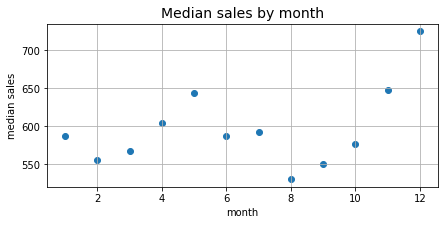

In [ ]:
x = range(1, 13)
plt.figure(figsize=(7, 3))
plt.grid()
plt.scatter(x, month_medians.median(axis=1))
plt.title('Median sales by month', size=14)
plt.xlabel('month')
plt.ylabel('median sales')
plt.show()

__Conclusion:__

Sales are affected by a seasonal factor - the time of the year. 
* They fall to the lowest level in August - September and then grow to the end of the year reaching the highest level at December.
* The second quiet season - February and March which is followed by the growth until May. 
* After sales reach the second pick in May, they stabilize at a lower level in June and July before falling in August.


#### Median sales by the day of the week

In [ ]:
weekday_medians = pd.pivot_table(
    data, index=data.index.weekday, aggfunc=np.median)

weekday_medians

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,748.400024,492.899994,586.449951,486.100006,385.880371,455.450012,636.650024,620.275024,1606.216797,727.375000,681.577759,485.325012,739.750000,704.365112,598.200012,784.799988,455.799988,458.683716,605.599976,412.899994
1,546.700012,357.500000,502.700012,243.350006,398.799988,460.250000,616.500000,561.750000,1602.000000,711.050049,719.950012,403.700012,391.799988,582.799316,378.700012,668.349976,410.950012,432.549988,460.900024,293.150024
3,976.950012,607.400024,714.599976,597.800049,417.536987,567.099976,846.500000,708.500000,1695.000000,1005.099976,741.918152,692.599976,1118.949951,815.099976,841.750000,1037.349976,541.400024,654.200012,882.799988,613.900024
4,858.200012,514.599976,627.500000,488.950012,377.599976,439.200012,649.449951,654.750000,1452.955200,822.250000,677.049988,567.950012,914.849976,681.373901,676.299988,813.050049,446.149994,515.748047,719.550049,521.900024
5,763.150024,465.750000,573.799988,430.649994,367.820068,422.049988,615.650024,609.349976,1444.042236,746.699951,637.459778,517.500000,764.800049,680.674866,611.550049,773.050049,426.399994,451.635864,655.400024,478.100006
6,803.800049,485.100006,583.449951,425.049988,372.400024,429.150024,599.950012,602.299988,1450.000000,744.950012,636.224976,501.399994,782.650024,685.575989,593.300049,761.750000,427.849976,468.537231,641.849976,455.250000


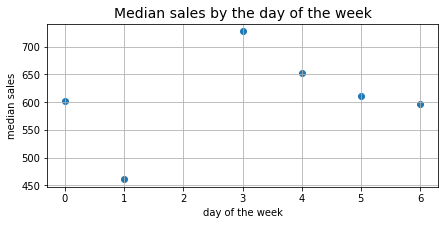

In [ ]:
x = range(7)
plt.figure(figsize=(7, 3))
plt.grid()
plt.scatter(weekday_medians.index, weekday_medians.median(axis=1))
plt.title('Median sales by the day of the week', size=14)
plt.xlabel('day of the week')
plt.ylabel('median sales')
plt.show()

Sales are affected by seasonality factor - day of the week. They reach the highest level on Wednesdays and then steady decrease to the weekends and finally drop on Mondays.

### Conclusions
 * We have seasonal time series with superposition of two factors: recurring changes associated with the day of the week and with the month of the year.
 * Seasonal annual variance of data is too high to be neglected. To capture it we need data for at least 2 years. Naive forecast should be factored into the model as well as the first difference of current and the previous year sales. 
 * Only 6 months of relevant data with a history of previous year is availible starting from Monday 2017-01-03 till Tursday 2017-06-30 with the corresponding prior year period from Monday 2016-01-05 till Tursday 2016-07-01. So, for training and validation of the model we have 153 days.
 * As we need to make a prediction for the 27 consecutive days, the model which works with the sequences of data, e.g. LSTM model will be appropriate. 

## 4. Training period

In [ ]:
t0 = pd.to_datetime('2016-01-05')
t1 = pd.to_datetime('2016-07-01')
t2 = pd.to_datetime('2017-01-03')
print(f'2016-01-05 weekday: {t0.weekday()}')
print(f'2017-01-03 weekday: {t2.weekday()}')

X0 = data[t0 : t1]
X1 = data[t2:]
X0.shape, X1.shape

2016-01-05 weekday: 1
2017-01-03 weekday: 1


((153, 20), (153, 20))

In [ ]:
time_shift  = np.argwhere(data.index==t0)[0][0]
time_shift

3

## 5. Data transformations

### 5.1 Johnson SU transformation

In [ ]:
class JohnsonSU():
  """
    Johnson SU transformation according to
    https://en.wikipedia.org/wiki/Johnson%27s_SU-distribution
  """
  def __init__(self):    
    self.johnsonsu_params = dict()


  def johnsonsu_transform(self, x, a, b, loc, scale):     
     return a + b * math.asinh((x - loc) / scale)


  def johnsonsu_inv_transform(self, x, a, b, loc, scale):    
    return loc + scale * math.sinh((x - a) / b)

    
  def fit(self, X):
    X = X.copy()    
    for i in range(n_shops):      
      self.johnsonsu_params[i] = st.johnsonsu.fit(X[i])
      

  def transform(self, X):
    X = X.copy()
    for i in range(n_shops): 
      a, b, loc, scale = self.johnsonsu_params[i]            
      X[i] = X[i].apply(self.johnsonsu_transform, args=(a, b, loc, scale))

    return X


  def inv_transform(self, X):
    X = X.copy()    
    for i in range(n_shops): 
      a, b, loc, scale = self.johnsonsu_params[i]           
      X[i] = X[i].apply(self.johnsonsu_inv_transform, args=(a, b, loc, scale))

    return X

In [ ]:
scaler = JohnsonSU()
scaler.fit(data)
X_scaled = scaler.transform(data)

In [ ]:
stats = X_scaled.describe()
stats

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000,468.000000
mean,0.002426,0.000811,-0.000006,0.002426,-0.000115,0.000857,0.000078,0.000078,0.000840,-0.000209,0.000260,0.000492,0.001518,0.000183,0.001256,0.000042,0.000198,0.000150,0.001338,0.001236
std,1.001861,1.001046,1.001230,1.000339,1.000988,1.000690,0.999675,1.000951,1.001196,1.001178,1.000060,0.999900,1.000628,1.001110,1.001702,1.000944,1.001045,1.001730,1.001077,1.001276
min,-2.906023,-2.803895,-3.848449,-2.163713,-3.015614,-3.008918,-2.552632,-3.568595,-2.797042,-3.471234,-3.042891,-3.489747,-2.192729,-4.080070,-2.700620,-3.408853,-3.376266,-3.426218,-3.053749,-2.867160
25%,-0.737004,-0.687116,-0.762773,-0.708118,-0.686164,-0.760235,-0.713840,-0.740484,-0.670622,-0.760614,-0.741677,-0.793295,-0.520708,-0.757631,-0.625131,-0.740269,-0.734581,-0.805079,-0.773410,-0.689971
50%,0.028804,0.075456,-0.052934,0.019381,0.016791,0.073270,0.051057,-0.057399,0.046193,0.027917,0.052823,0.040301,-0.022756,0.039191,0.014850,0.003858,0.022184,0.050144,-0.015299,0.008202
75%,0.699588,0.654951,0.752915,0.771408,0.646326,0.690826,0.694160,0.740702,0.680308,0.735951,0.687315,0.739959,0.694419,0.784944,0.714746,0.671909,0.647081,0.690842,0.785801,0.737311
max,2.463480,2.829428,2.383205,2.330275,2.675623,3.020435,2.416018,2.432681,3.030357,2.575278,3.406735,2.219315,2.645457,2.257927,2.513060,2.530600,2.828089,2.775197,2.231670,2.832155


### 5.2 Clean outliers

In [ ]:
iqr = stats.loc['75%'] - stats.loc['25%']
outliers_level_lower = stats.loc['25%'] - 1.5 * iqr
outliers_level_upper = stats.loc['75%'] + 1.5 * iqr

n_outliers = (X_scaled > outliers_level_upper).sum().sum() +\
             (X_scaled < outliers_level_lower).sum().sum()
print(f'Number of outliers = {n_outliers}') 

Number of outliers = 33


In [ ]:
for i in range(n_shops):
  X_scaled[i] = np.clip(
      X_scaled[i], outliers_level_lower[i], outliers_level_upper[i])

In [ ]:
def plot_sales(X, shop):
  plt.figure(figsize = (12, 3))
  sns.scatterplot(data=X[shop]).set_title(f'Shop {shop}')
  plt.xlabel ('Time')
  plt.ylabel ('Sales');

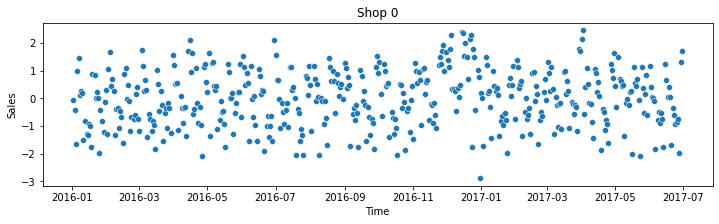

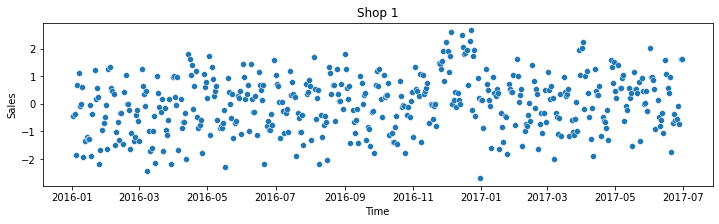

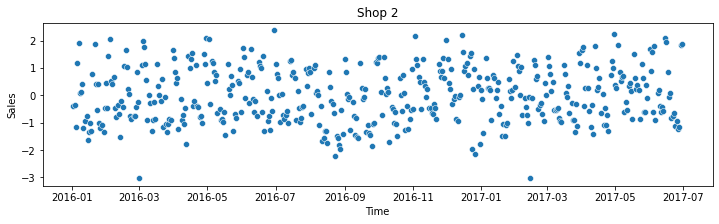

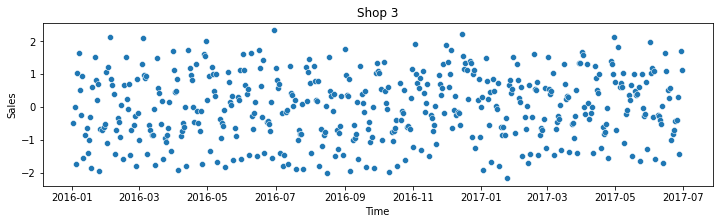

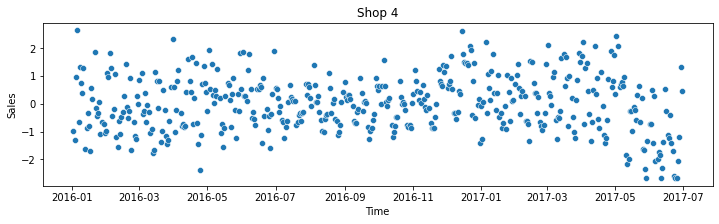

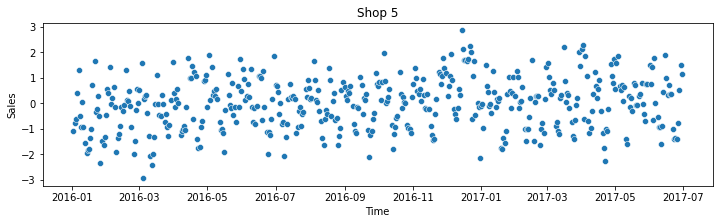

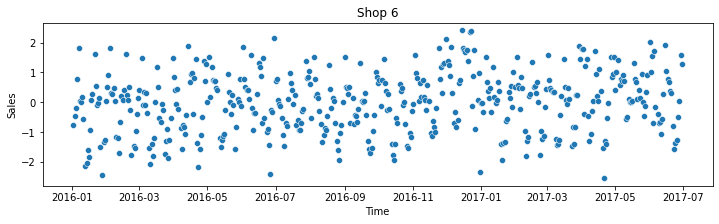

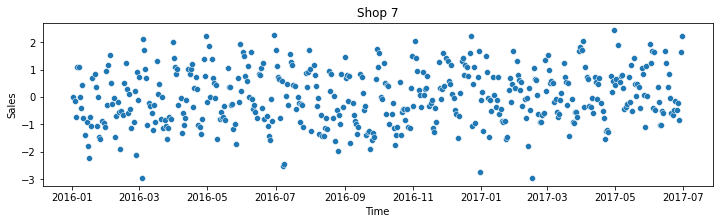

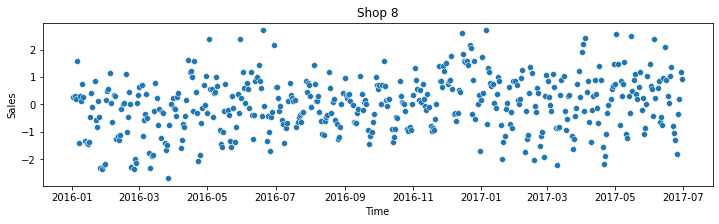

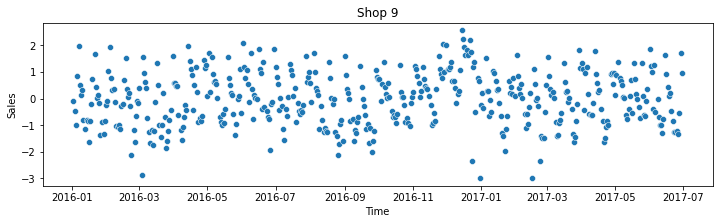

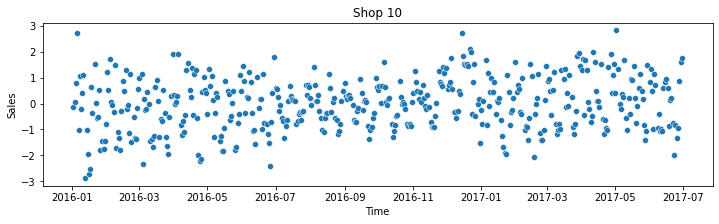

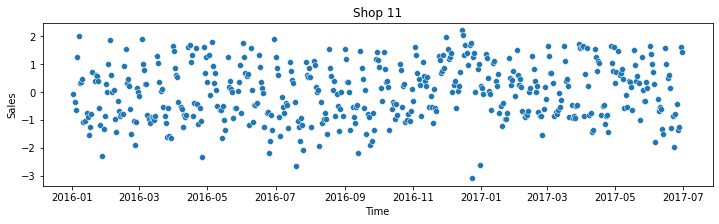

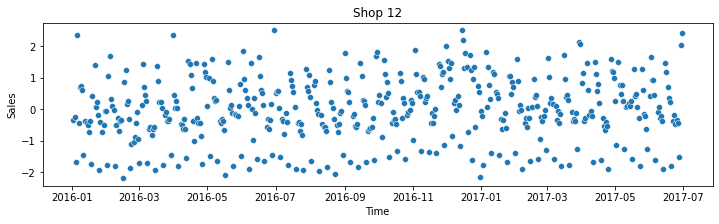

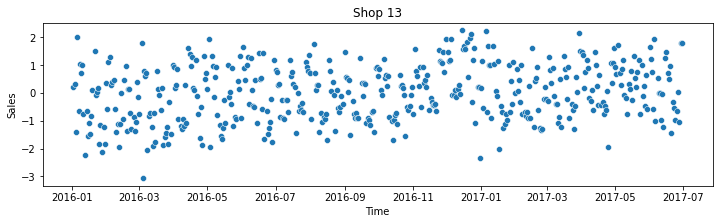

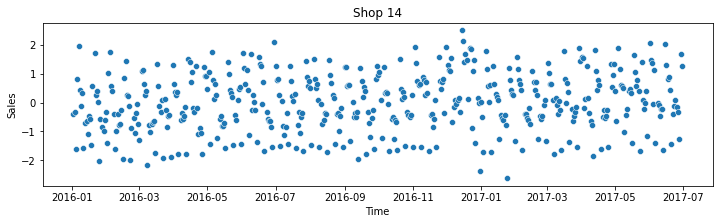

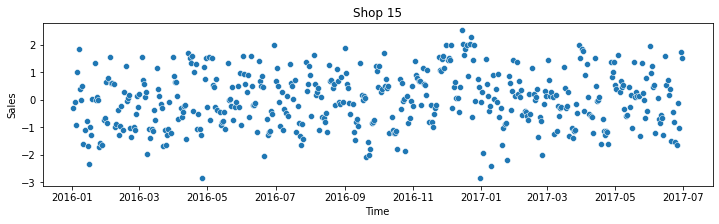

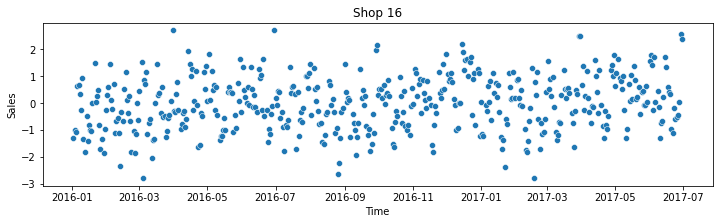

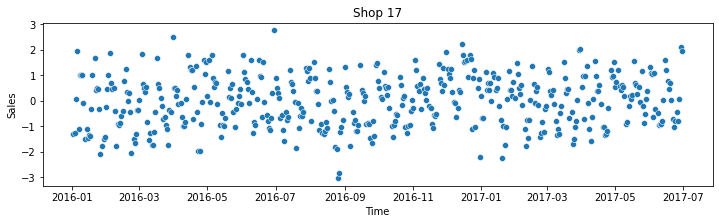

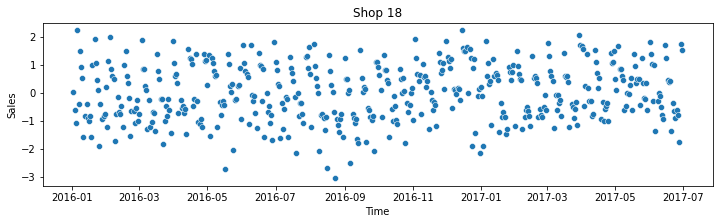

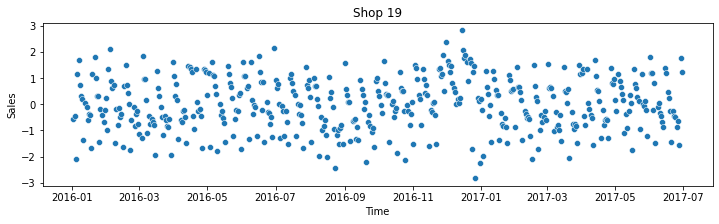

In [ ]:
for shop in range(n_shops):
  plot_sales(X_scaled, shop)

### 5.3 Feature engineering

In [ ]:
def get_1st_differences(t='W', param='absolute'):
  a0 = X_scaled[[0]]
  a1 = X_scaled.resample(t).median()
  a2 = pd.DataFrame(0, index=a1.index, columns=range(n_shops))
  if param == 'absolute':
    a2.iloc[1:, :] = a1.values[1:, :] - a1.values[:-1, :]
  elif param == 'rate':
    a2.iloc[1:, :] = (a1.values[1:, :] - a1.values[:-1, :]) / a1.values[:-1, :]
  a3 = pd.concat([a0, a2], axis=1).bfill().iloc[:, 1:]

  return pd.concat([a0, a3], axis=1, join='inner').iloc[:, 1:]


def get_2nd_differences(t='W'):
  a0 = X_scaled[[0]]
  a1 = X_scaled.resample(t).median()

  a2 = pd.DataFrame(0, index=a1.index, columns=range(n_shops))
  a3 = pd.DataFrame(0, index=a1.index, columns=range(n_shops))
  
  a2.iloc[1:, :] = a1.values[1:, :] - a1.values[:-1, :]
  a3.iloc[1:, :] = a2.values[1:, :] - a2.values[:-1, :]
  a3.iloc[:2, :] = 0
 
  a4 = pd.concat([a0, a3], axis=1).bfill().iloc[:, 1:]

  return pd.concat([a0, a4], axis=1, join='inner').iloc[:, 1:]


def get_moments(t='W', moment='median'):
  a0 = X_scaled[[0]]
  if moment == 'median':
    a1 = X_scaled.resample(t).median()
  elif moment == 'mean':
    a1 = X_scaled.resample(t).mean()
  elif moment == 'std':
    a1 = X_scaled.resample(t).std()
  elif moment == 'skew':
    a1 = X_scaled.resample(t).agg(st.skew)
  elif moment == 'kurtosis':
    a1 = X_scaled.resample(t).agg(st.kurtosis)
  a2 = pd.concat([a0, a1], axis=1).bfill().iloc[:, 1:]

  return pd.concat([a0, a2], axis=1, join='inner').iloc[:, 1:]

In [ ]:
def get_features(X_scaled):  
  n_features = 30  
  time_seq = 153
  X = np.empty((time_seq, n_shops, n_features))

  X[:, :, 0] = X_scaled.iloc[-time_seq:, :]        # actual sales
  X[:, :, 1] = X_scaled.iloc[time_shift:time_shift + time_seq, :]  # naive forecast 
  X[:, :, 2] = X_scaled.iloc[-time_seq - 6:-6, :]  # previous week sales

  # 1st order differences
  X[1:, :, 3] = X[1:, :, 0] - X[:-1, :, 0]   # difference with the previous day
  X[:, :, 4] = X[:, :, 0] - X[:, :, 1]       # difference with the previous year
  X[:, :, 5] = X[:, :, 0] - X[:, :, 2]       # difference with the previous week

  X[:, :, 6] = get_1st_differences(t='W', param='absolute')[-time_seq:]
  X[:, :, 7] = get_1st_differences(t='M', param='absolute')[-time_seq:]
  X[:, :, 8] = get_1st_differences(t='Q', param='absolute')[-time_seq:]

  # rate of change
  X[1:, :, 9] = X[1:, :, 3] / X[:-1, :, 0]
  X[:, :, 10] = get_1st_differences(t='W', param='rate')[-time_seq:]
  X[:, :, 11] = get_1st_differences(t='M', param='rate')[-time_seq:]
  X[:, :, 12] = get_1st_differences(t='Q', param='rate')[-time_seq:]

  # 2nd order differences
  X[1:, :, 13] = X[1:, :, 3] - X[:-1, :, 3]
  X[:, :, 14] = get_2nd_differences(t='W')[-time_seq:]
  X[:, :, 15] = get_2nd_differences(t='M')[-time_seq:]

  # medians and means for a week
  X[:, :, 16] = get_moments('W', 'median')[-time_seq:]
  X[:, :, 17] = get_moments('W', 'mean')[-time_seq:]

  # medians and central moments for a month
  X[:, :, 18] = get_moments('M', 'median')[-time_seq:]
  X[:, :, 19] = get_moments('M', 'mean')[-time_seq:]
  X[:, :, 20] = get_moments('M', 'std')[-time_seq:]
  X[:, :, 21] = X[:, :, 19] / X[:, :, 20]                   # mean / std
  X[:, :, 22] = get_moments('M', 'skew')[-time_seq:]
  X[:, :, 23] = get_moments('M', 'kurtosis')[-time_seq:]  # excess kurtosis

  # medians for a quarter
  X[:, :, 24] = get_moments('Q', 'median')[-time_seq:]

  # rolling means
  X[:, :, 25] = X_scaled.rolling(6).mean()[-time_seq:]   # week
  X[:, :, 26] = X_scaled.rolling(24).mean()[-time_seq:]  # month
  X[:, :, 27] = X_scaled.rolling(72).mean()[-time_seq:]  # quarter 

  # cluster variables
  kmeans = KMeans(n_clusters=3, random_state=0).fit(X_scaled.T)  
  X[:, :, 28] = np.asarray([kmeans.labels_ == 0] * time_seq)
  X[:, :, 29] = np.asarray([kmeans.labels_ == 1] * time_seq)
  
 
  return X

In [ ]:
X = get_features(X_scaled)
X = np.nan_to_num(X)
X.shape

(153, 20, 30)

## 6. Train dataset formation

In [ ]:
n_features = X.shape[2]
n_train = X.shape[0]

In [ ]:
def get_train_dataset(X, input_sequence_length, output_sequence_length):  
  X_train, y_train = [], [] 
  n = n_train - (input_sequence_length + output_sequence_length)
  list_train = list(range(n))
  np.random.shuffle(list_train)
  
  for t0 in list_train:
    t1 = t0 + input_sequence_length
    t2 = t1 + output_sequence_length
    for j in range(n_shops):
      input_ = X[t0 : t1, j, :]
      output_ = X[t1 : t2, j, :]
      X_train.append(input_)
      y_train.append(output_)

  return np.array(X_train), np.array(y_train)

In [ ]:
input_sequence_length, output_sequence_length = 54, 27
X_train, y_train = get_train_dataset(
    X, input_sequence_length, output_sequence_length)

X_train.shape, y_train.shape

((1440, 54, 30), (1440, 27, 30))

## 7. Model Transformer + Time2Vec

### 7.1 Model architecture

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, feat_dim, num_heads, ff_dim, rate = 0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
        self.ffn = keras.Sequential( [layers.Dense(ff_dim, activation = "gelu"), layers.Dense(feat_dim),] )
        self.layernorm1 = layers.BatchNormalization()
        self.layernorm2 = layers.BatchNormalization()
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training = training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training = training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class Time2Vec(tf.keras.layers.Layer):
    def __init__(self, kernel_size = 1):
        super(Time2Vec, self).__init__(trainable = True, name = 'Time2VecLayer')
        self.k = kernel_size

    def build(self, input_shape):
        # trend
        self.wb = self.add_weight(name = 'wb', shape = (input_shape[1],), initializer = 'uniform', trainable = True)
        self.bb = self.add_weight(name = 'bb', shape = (input_shape[1],), initializer = 'uniform', trainable = True)
        # periodic
        self.wa = self.add_weight(name = 'wa', shape = (1, input_shape[1], self.k), initializer = 'uniform', trainable = True)
        self.ba = self.add_weight(name = 'ba', shape = (1, input_shape[1], self.k), initializer = 'uniform', trainable = True)
        super(Time2Vec, self).build(input_shape)

    def call(self, inputs, **kwargs):
        bias = self.wb * inputs + self.bb
        dp = K.dot(inputs, self.wa) + self.ba
        wgts = K.sin(dp) # or K.cos(.)
        ret = K.concatenate([K.expand_dims(bias, -1), wgts], -1)
        ret = K.reshape(ret, (-1, inputs.shape[1] * (self.k + 1)))
        return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] * (self.k + 1))

In [ ]:
N_HEADS = 3
FF_DIM = 256
N_BLOCKS = 6
EMBED_DIM = 64
DROPUT_RATE = 0.1
TIME_2_VEC_DIM = 3
SKIP_CONNECTION_STRENGTH = 0.9

In [ ]:
def get_model_TF(input_shape, time2vec_dim=1):
  # encoder  
  encoder_inputs = layers.Input(input_shape) 
  x = encoder_inputs
  time_embedding = layers.TimeDistributed(Time2Vec(time2vec_dim - 1))(x)
  x = layers.Concatenate(axis=-1)([x, time_embedding])
  x = layers.LayerNormalization(epsilon=1e-6)(x)

  for k in range(N_BLOCKS):
    x_old = x
    transformer_block = TransformerBlock(EMBED_DIM, input_shape[-1] + (input_shape[-1] * time2vec_dim), N_HEADS, FF_DIM, DROPUT_RATE)
    x = transformer_block(x)
    x = ((1.0 - SKIP_CONNECTION_STRENGTH) * x) + (SKIP_CONNECTION_STRENGTH * x_old)

  encoder_outputs = layers.Flatten()(x)   
  
  # decoder  
  decoder_inputs = layers.RepeatVector(output_sequence_length)(encoder_outputs)           
  x = layers.TimeDistributed(layers.Dense(n_features, activation="selu"))(decoder_inputs)

  for k in range(N_BLOCKS):
    x_old = x
    transformer_block = TransformerBlock(EMBED_DIM, input_shape[-1], N_HEADS, FF_DIM, DROPUT_RATE)
    x = transformer_block(x)
    x = ((1.0 - SKIP_CONNECTION_STRENGTH) * x) + (SKIP_CONNECTION_STRENGTH * x_old)  

  decoder_outputs = x
  
  # model
  model = tf.keras.models.Model(encoder_inputs, decoder_outputs)

  return model

In [ ]:
model = get_model_TF(X_train.shape[1:], TIME_2_VEC_DIM)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 54, 30)]     0           []                               
                                                                                                  
 time_distributed_2 (TimeDistri  (None, 54, 90)      180         ['input_2[0][0]']                
 buted)                                                                                           
                                                                                                  
 concatenate_1 (Concatenate)    (None, 54, 120)      0           ['input_2[0][0]',                
                                                                  'time_distributed_2[0][0]']     
                                                                                            

### 7.2 Training the model

In [ ]:
n_epochs = 20
batch_size = 80

reduce_lr = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 3e-2 * 0.95 ** epoch)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.Huber())

history = model.fit(X_train[:-80, :, :], y_train[:-80, :, :], epochs=n_epochs,
                    validation_data=(X_train[-80:, :, :], y_train[-80:, :, :]),
                    batch_size=batch_size, verbose=1,
                    callbacks=[reduce_lr]
                    )

Epoch 1/20
17/17 [==============================] - 11s 174ms/step - loss: 3.0723 - val_loss: 8504636.0000 - lr: 0.0300
Epoch 2/20
17/17 [==============================] - 1s 75ms/step - loss: 2.8275 - val_loss: 4055.4375 - lr: 0.0285
Epoch 3/20
17/17 [==============================] - 1s 76ms/step - loss: 2.7310 - val_loss: 25.4347 - lr: 0.0271
Epoch 4/20
17/17 [==============================] - 1s 77ms/step - loss: 2.6715 - val_loss: 5.6528 - lr: 0.0257
Epoch 5/20
17/17 [==============================] - 1s 76ms/step - loss: 2.6368 - val_loss: 3.5090 - lr: 0.0244
Epoch 6/20
17/17 [==============================] - 1s 76ms/step - loss: 2.6170 - val_loss: 2.9161 - lr: 0.0232
Epoch 7/20
17/17 [==============================] - 1s 76ms/step - loss: 2.6061 - val_loss: 2.8698 - lr: 0.0221
Epoch 8/20
17/17 [==============================] - 1s 76ms/step - loss: 2.6002 - val_loss: 2.8463 - lr: 0.0210
Epoch 9/20
17/17 [==============================] - 1s 77ms/step - loss: 2.5971 - val_loss: 

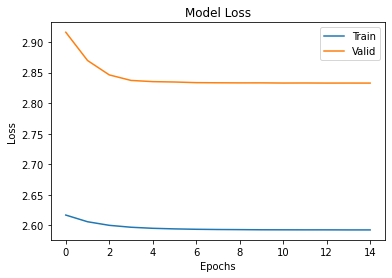

In [ ]:
plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

### 7.3 Prediction on validation sample

In [ ]:
pred = model.predict(X_train[-80:, :, :])
pred.shape

(80, 27, 30)

### 7.4 Model evaluation

#### Mean absolute scaled error (MASE) 
https://en.wikipedia.org/wiki/Mean_absolute_scaled_error

We have seasonal time series with superposition of two factors:  recurring changes associated with the day of the week and with the month of the year.
The denominator of mean absolute scaled error is the mean absolute error of the one-step "seasonal naive forecast method" on the training set, which uses the actual value from the prior season as the forecast: 
* F(t) = Y(t−m), where m is the seasonal period.

In the naive seasonal forecast, the first Wednesday of January will be set at the level of the first Wednesday of January of the previous year and definetely not at the level of the the last Wednesday of December - the week number should match.

MASE is scale-free error metric. So, it can applied to scaled data without extra iteration of inverse scaling.

In [ ]:
forecast_error = abs(pred[:, :, 0] - y_train[-80:, :, 0]).mean()
seasonal_naive_forecast_error = abs(y_train[-80:, :, 2] - y_train[-80:, :, 0]).mean() 

mase = forecast_error / seasonal_naive_forecast_error
print(f'Mean absolute scaled error = {round(mase.mean(), 4)}')

Mean absolute scaled error = 0.759


More accurate value of mean absolute scaled error could be obtained through cross-validation.

### 7.5 Final prediction

#### Dataset

In [ ]:
X_test = []
for j in range(n_shops):
  input_ = X[-input_sequence_length:, j, :]
  X_test.append(input_)

X_test = np.array(X_test)

#### Prediction

In [ ]:
pred_final = model.predict(X_test)

#### Inverse transformation of predictions

In [ ]:
arr_pred = pred_final[:, :, 0]
y_pred = pd.DataFrame(arr_pred).T
y_pred_rescaled = scaler.inv_transform(y_pred)
y_pred_rescaled.shape

(27, 20)

#### Generation of the final result

In [ ]:
for i in range(n_shops):
  predict_example.loc[predict_example['id'] == i, 'target'] = y_pred_rescaled.loc[:, i]

predict_example.to_csv('sales_forecast_lstm.csv', index=False)
predict_example.head()

,id,dt,target
0,0,2017-07-01,787.578489
1,0,2017-07-02,787.578489
2,0,2017-07-03,787.578489
3,0,2017-07-04,787.578489
4,0,2017-07-06,787.578489


## 8. Conclusions

* LSTM model has not generated the prominent results. However, model predictions are better than the naive forecast with the data for the previous year. 

* More accurate value of mean absolute scaled error with the confidence intervals could be obtained through cross-validation. As I ran out of colab time, I could not afford cross-validation as well as hyperparameter tuning togeter with other experiments and just mention them below.

* Seasonal annual variance of data is too high to be neglected. To capture it we need data for at least 2 years. Naive forecast should be factored into the model as well as the first difference of current and the previous year sales. Available data covers only half a year, luckily this half a year is followed by prediction period.

* The model based on transformers with attention might improve the results. LSTM puts an accents on the neibouring cells, while transformer with attention will consider the whole sequence to pick up the best match. As our  data has a strong weekly cycle, transformer with attention might generate more accurate predictions.

* Ensemble of LSTM models and transformers could reduce the variance of predictions and presumably improve the accuracy of the forecast. The results of various models could be avereged or used as an imput data in linear regression fitted agaist actual sales of corresponding shops. The final forecast will be generated either based on equally weighted predictions of selected models or predictions weighted accoding to coefficients of linear regression.